In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In this notebook, we are attempting to predict houseprices, given data about houses that we know the value for. We will wrangle the data to represent it in a way that the machine learning models can use. Then we will train various types of regression models such as ridge regression, elastic net regression, support vector machine regression, and xgboost regression.

So first, we load into the data and look what attributes we are working with.

In [30]:
training_data = pd.read_csv("train.csv")

In [31]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Numerical Wrangling

To start, we look at the distribution of house prices in our dataset. Houseprices are likely to be right skewed, so we are going to transform it by making it look more gaussian and removing outliers which will likely negatively influence our future models.

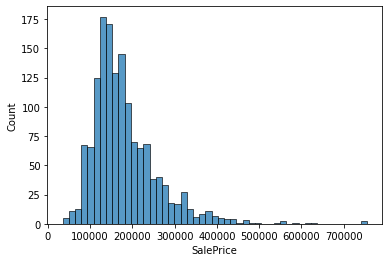

In [32]:
sns.histplot(data=training_data, x = "SalePrice");

In [33]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
    """
    data = data[data[variable] >= lower]
    data = data[data[variable] <= upper]
    return data

training_data = remove_outliers(training_data, "LotArea", upper = 50000)
#training_data = remove_outliers(training_data, "LotFrontage", upper = 300)

In [34]:
training_data.shape

(1449, 81)

Removing some of the very large houses only removes 11 data points so we are not likely losing important information.

In [35]:
def add_log(data):
    """
    Input:
      data (data frame): the table to be filtered
    
    Output:
      a data frame with the log of House Prices added
    """
    data["log(SalePrice)"] = np.log(data["SalePrice"])
    return data

training_data["log(SalePrice)"] = np.log(training_data["SalePrice"])

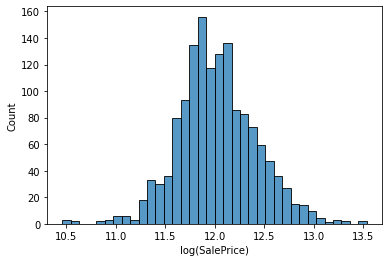

In [36]:
sns.histplot(data = training_data, x = "log(SalePrice)");

After taking to log of the house prices, the distribution look a lot more symmetrical! We also look through the attributes to see which ones are quantitative and continuous, and we will work with the categorical variables later.

In [37]:
numerical_columns = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "MasVnrArea", "BsmtFinSF1",
                     "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                    "GrLivArea", "GarageYrBlt", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
                    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

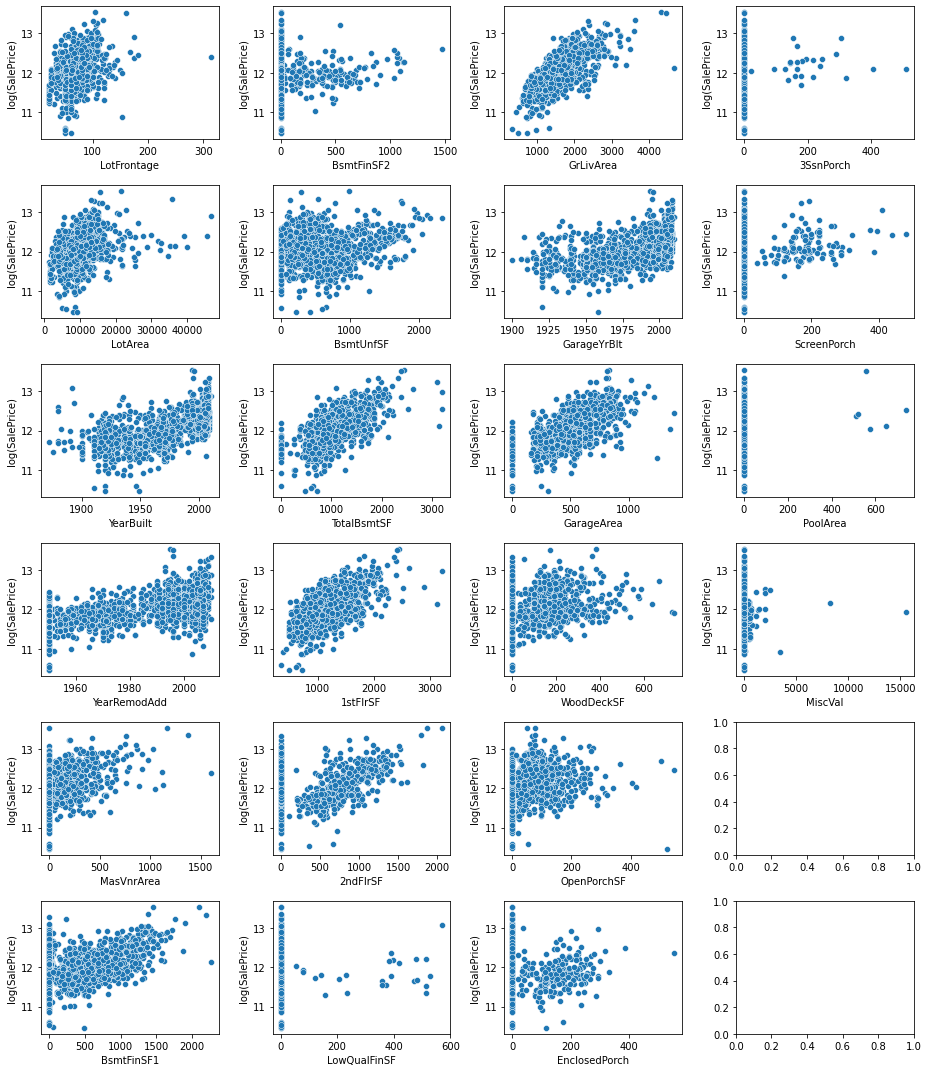

In [38]:
def view_relationship(rows, cols, columns):
    """
    Input:
      rows (int): number of rows for the figure
      cols (int): number of columns for the figure
      columns (list of strings): list of attributes to plot against the house prices
    
    Output:
      a grid of scatterplots of the listed attribute against house prices
    """
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (13, 15))
    i, j = 0, 0
    
    for attribute in columns:
        if i < rows:
            sns.scatterplot(data = training_data, x = attribute, y = "log(SalePrice)", ax = ax[i,j])
        else:
            i = 0
            j += 1
            sns.scatterplot(data = training_data, x = attribute, y = "log(SalePrice)", ax = ax[i,j])
        i += 1
    plt.tight_layout();

view_relationship(6, 4, numerical_columns);

Taking a look at all the variables and their relationships can show which variables are likely to be more predictive and which variables are likely not going to help at all. While other techniques such as PCA, LASSO, or the statsmodel.api can show us more quantitatively and directly, this is sufficient to get a quick look at all the variables of interest. We can simply just drop the variables that have mostly null values 

In [39]:
numerical_columns2 = ["LotFrontage", "LotArea", "YearBuilt", 
                             "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", 
                     "2ndFlrSF", "GrLivArea", "GarageArea"]

We can also create a correlation heatmap to get a quick sense of whether we have significant multicollinearity in the dataset, but the modeling techniques we will be using will likely to not be too negatively affected by it.

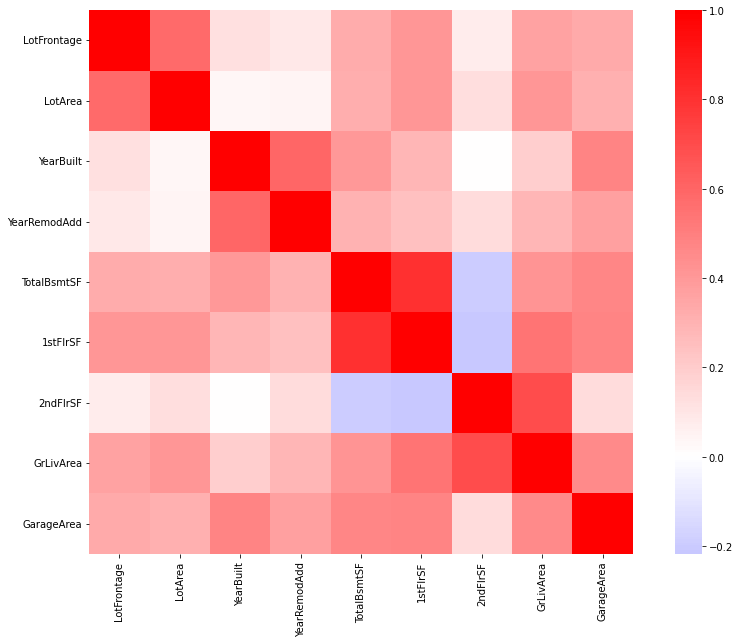

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(training_data[numerical_columns2].corr(), square = True, center = 0, cmap = "bwr");

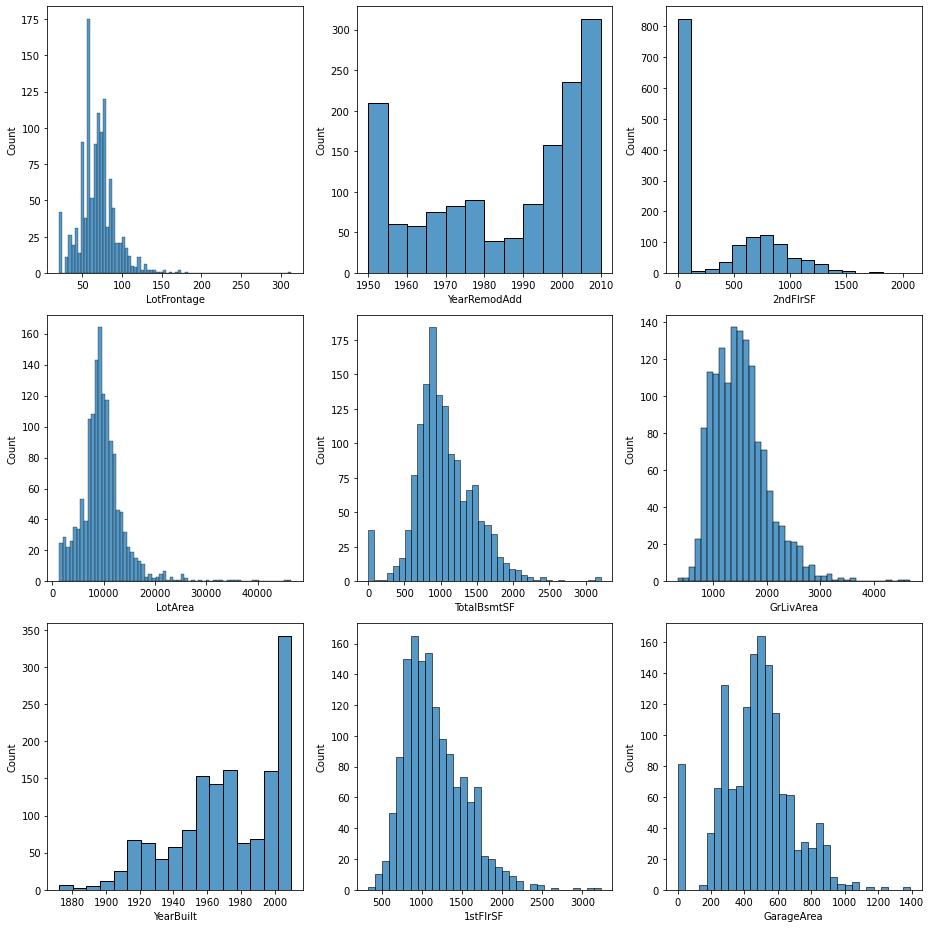

In [41]:
def view_distribution(rows, cols, columns):
    """
    Similar to view_relationship, but plots histograms to visualize distributions instead.
    """
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (13, 13))
    i, j = 0, 0
    
    for attribute in columns:
        if i < rows:
            sns.histplot(data = training_data, x = attribute, ax = ax[i,j])
        else:
            i = 0
            j += 1
            sns.histplot(data = training_data, x = attribute, ax = ax[i,j])
        i += 1
    plt.tight_layout();
    
view_distribution(3, 3, numerical_columns2);

Similarly to how we transformed the house prices do a gaussian symmetric shape by taking the log of it, we will also be doing that the the skewed numerical attributes. We also decide to use a total floor square feet instead of the 2ndFloorSF because there are quite a few houses that are only one story.

In [42]:
def numerical_transform(data):
    data["log(LotArea)"] = np.log(data["LotArea"] + 1)
    data["log(TotalBsmtSF)"] = np.log(data["TotalBsmtSF"] + 1)
    data["log(1stFlrSF)"] = np.log(data["1stFlrSF"])
    data["log(BothFlrSF)"] = np.log(data["2ndFlrSF"] + data["1stFlrSF"])
    data["log(GrLivArea)"] = np.log(data["GrLivArea"] + 1)
    data["log(GarageArea)"] = np.log(data["GarageArea"] + 1)
    return data

training_data = numerical_transform(training_data)

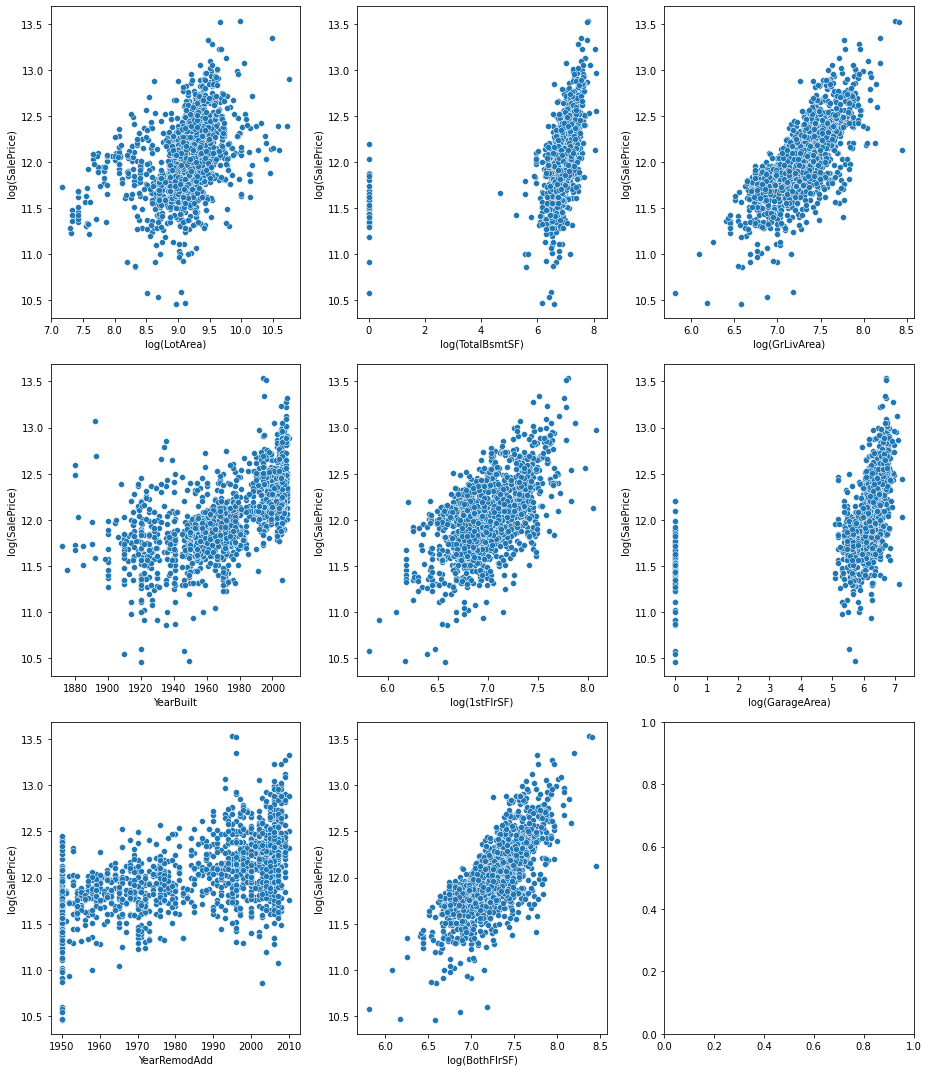

In [43]:
numerical_columns3 = ["log(LotArea)", "YearBuilt", 
                             "YearRemodAdd", "log(TotalBsmtSF)", "log(1stFlrSF)", 
                     "log(BothFlrSF)", "log(GrLivArea)", "log(GarageArea)"]
view_relationship(3, 3, numerical_columns3);

# Categorical Wrangling
# -----------------------------------------------------------------------------------------

Now that we have finished with the numerical variables, we do a similar thing and take a look at all of the categorical variables. We choose ignore the pool variable due to the low number of houses having pools in our dataset.

In [44]:
categorical_columns = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                     "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2",
                    "BldgType", "HouseStyle", "OverallQual", "OverallCond", "RoofStyle", "RoofMatl",
                    "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation",
                      "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating",
                      "HeatingQC", "CentralAir", "Electrical", "BsmtFullBath", "BsmtHalfBath", "FullBath",
                      "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional",
                      "Fireplaces", "FireplaceQu", "GarageType", "GarageFinish", "GarageCars", "GarageQual",
                       "GarageCond", "PavedDrive", "Fence", "MiscFeature", "SaleType", "SaleCondition",
                      ]

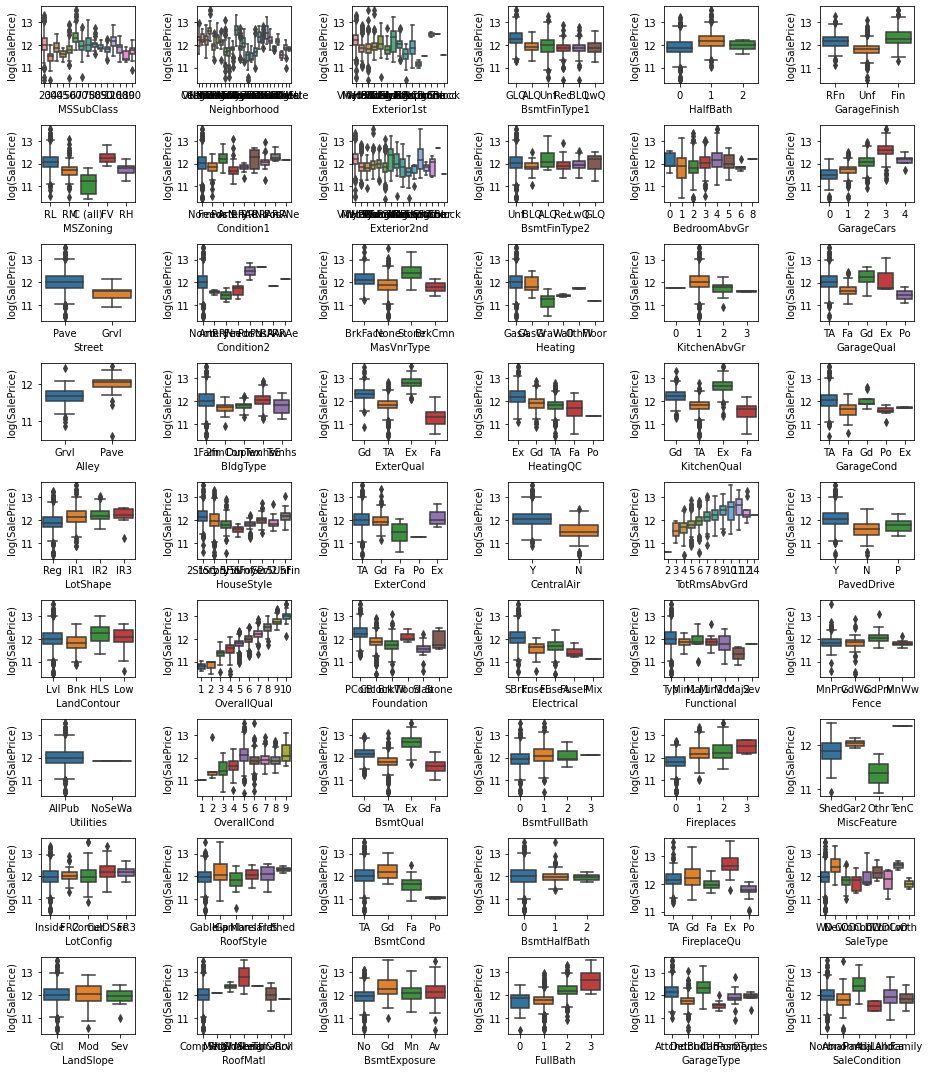

In [45]:
def view_categoricals(rows, cols, columns):
    """
    Similar to view_relationship, but uses boxplots to help visualize the data against house prices.
    """
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (13, 15))
    i, j = 0, 0
    
    for attribute in columns:
        if i < rows:
            sns.boxplot(data = training_data, x = attribute, y = "log(SalePrice)", ax = ax[i,j])
        else:
            i = 0
            j += 1
            sns.boxplot(data = training_data, x = attribute, y = "log(SalePrice)", ax = ax[i,j])
        i += 1
    plt.tight_layout();

view_categoricals(9, 6, categorical_columns)

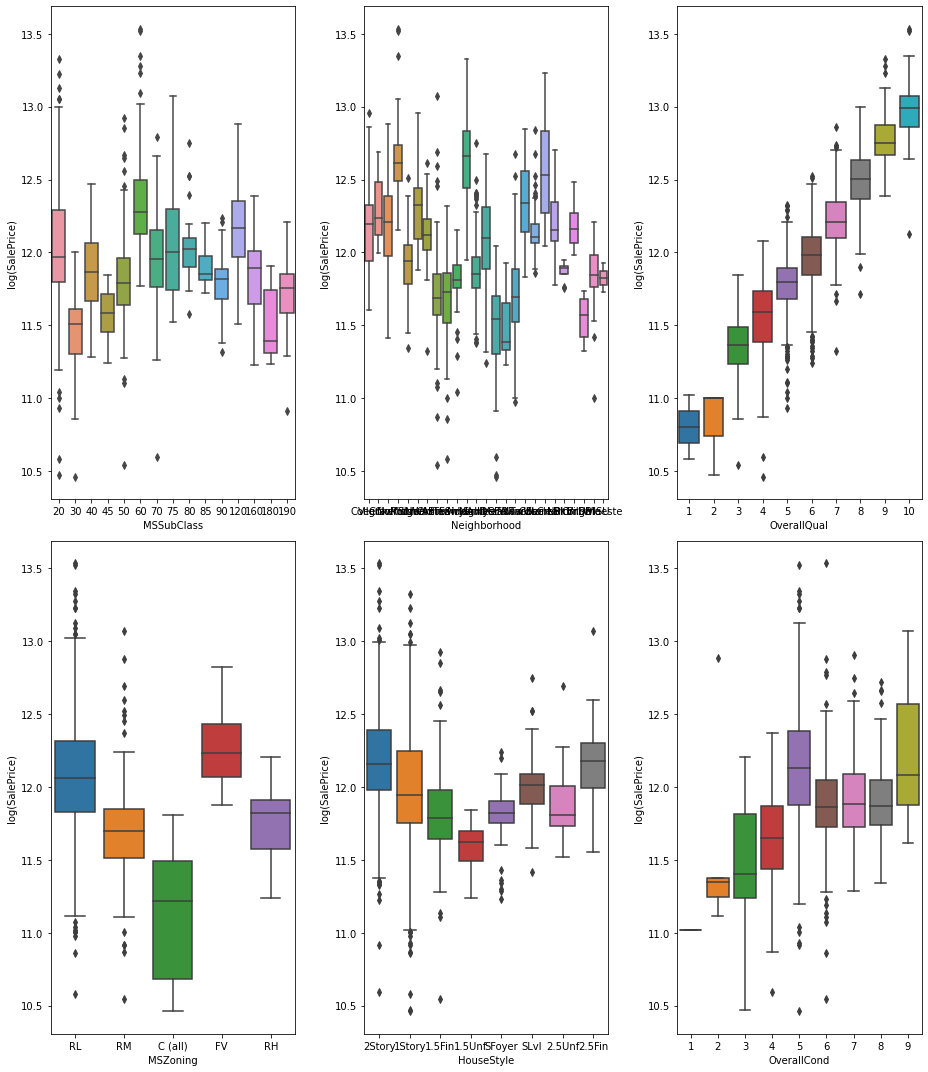

In [46]:
categorical_columns2 = ["MSSubClass", "MSZoning", "Neighborhood", "HouseStyle", 
                        "OverallQual", "OverallCond", "RoofMatl", "ExterQual", 
                        "ExterCond", "Foundation", "BsmtQual", "BsmtCond", 
                        "Heating", "HeatingQC", "CentralAir", "Electrical", 
                        "FullBath", "KitchenQual", "TotRmsAbvGrd", "Functional", 
                        "Fireplaces", "FireplaceQu", "GarageType", "GarageFinish", 
                        "GarageCars", "GarageQual", "PavedDrive", "MiscFeature", 
                        "SaleType", "SaleCondition",
                      ]
view_categoricals(2, 3, categorical_columns2[:6])

In [47]:
def condense_categories(data, train, attribute, number_c = 2, upper = 2, lower = 2):
    """
    Input:
      data (dataframe): dataframe of interest
      train (dataframe): dataframe of reference (the training dataset)
      attribute (string): the attribute of interest that is going to be tranformed
      number_c (int): number of categories (2 or 3)
      upper (int): the number of values in the upper category
      lower (int): the number of values in the lower category
    
    Output:
      the dataframe with the attribute values changed into categories.
    """
    # Gives a list of the values sorted by house price medians from largest to lowest.
    organized_attribute = (train[[attribute, "log(SalePrice)"]]
                     .groupby(attribute).agg(np.median)
                     .sort_values(by="log(SalePrice)", ascending=False)
                     .reset_index()[attribute]
                     .tolist())
    
    # Categorizes the values into three different descriptions: expensive ("ex"), normal ("n"), inexpensive ("inex")
    if number_c == 3:
        expensive = organized_attribute[:upper]
        normal = organized_attribute[2:len(organized_attribute)-lower]
        inexpensive = organized_attribute[-lower:]
        data[attribute] = data[attribute].replace(expensive, "ex").replace(normal, "n").replace(inexpensive,"inex").fillna("n")
    # Changes it to an indicator variable: 1 if expensive, 0 if not.
    else:
        expensive = organized_attribute[:upper]
        normal = organized_attribute[upper:]
        data[attribute] = data[attribute].isin(expensive).astype(int).fillna(0)
    return data

In [48]:
def categorical_transform(data, train):
    condense_categories(data, train, "MSSubClass", 3, 2, 2)
    condense_categories(data, train, "MSZoning", 3, 2, 1)
    condense_categories(data, train, "Neighborhood", 3, 3, 8)
    condense_categories(data, train, "HouseStyle", 3, 2, 1)
    condense_categories(data, train, "OverallCond", 2, 5)
    condense_categories(data, train, "RoofMatl", 2, 1)
    condense_categories(data, train, "ExterCond", 2, 3)
    condense_categories(data, train, "Foundation", 2, 2)
    condense_categories(data, train, "BsmtCond", 2, 2)
    condense_categories(data, train, "Heating", 2, 3)
    condense_categories(data, train, "HeatingQC", 2, 1)
    condense_categories(data, train, "Electrical", 2, 1)
    condense_categories(data, train, "Functional", 2, 6)
    condense_categories(data, train, "FireplaceQu", 3, 1, 1)
    condense_categories(data, train, "GarageType", 3, 2, 1)
    condense_categories(data, train, "GarageFinish", 2, 2)
    condense_categories(data, train, "GarageQual", 2, 3)
    condense_categories(data, train, "MiscFeature", 2, 1)
    condense_categories(data, train, "SaleType", 2, 2)
    condense_categories(data, train, "SaleCondition", 2, 1)
    return data

categorical_transform(training_data, training_data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,log(SalePrice),log(LotArea),log(TotalBsmtSF),log(1stFlrSF),log(BothFlrSF),log(GrLivArea),log(GarageArea)
0,1,ex,ex,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,208500,12.247694,9.042040,6.753438,6.752270,7.444249,7.444833,6.308098
1,2,n,ex,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,181500,12.109011,9.169623,7.141245,7.140453,7.140453,7.141245,6.133398
2,3,ex,ex,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,223500,12.317167,9.328212,6.825460,6.824374,7.487734,7.488294,6.411818
3,4,n,ex,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,140000,11.849398,9.164401,6.629363,6.867974,7.448334,7.448916,6.466145
4,5,ex,ex,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,250000,12.429216,9.565284,7.044033,7.043160,7.695303,7.695758,6.729824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,ex,ex,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,175000,12.072541,8.976894,6.860664,6.859615,7.406711,7.407318,6.133398
1456,1457,n,ex,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,210000,12.254863,9.486152,7.341484,7.636752,7.636752,7.637234,6.216606
1457,1458,n,ex,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,266500,12.493130,9.109746,7.050123,7.080026,7.757906,7.758333,5.533389
1458,1459,n,ex,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,142125,11.864462,9.181735,6.983790,6.982863,6.982863,6.983790,5.484797


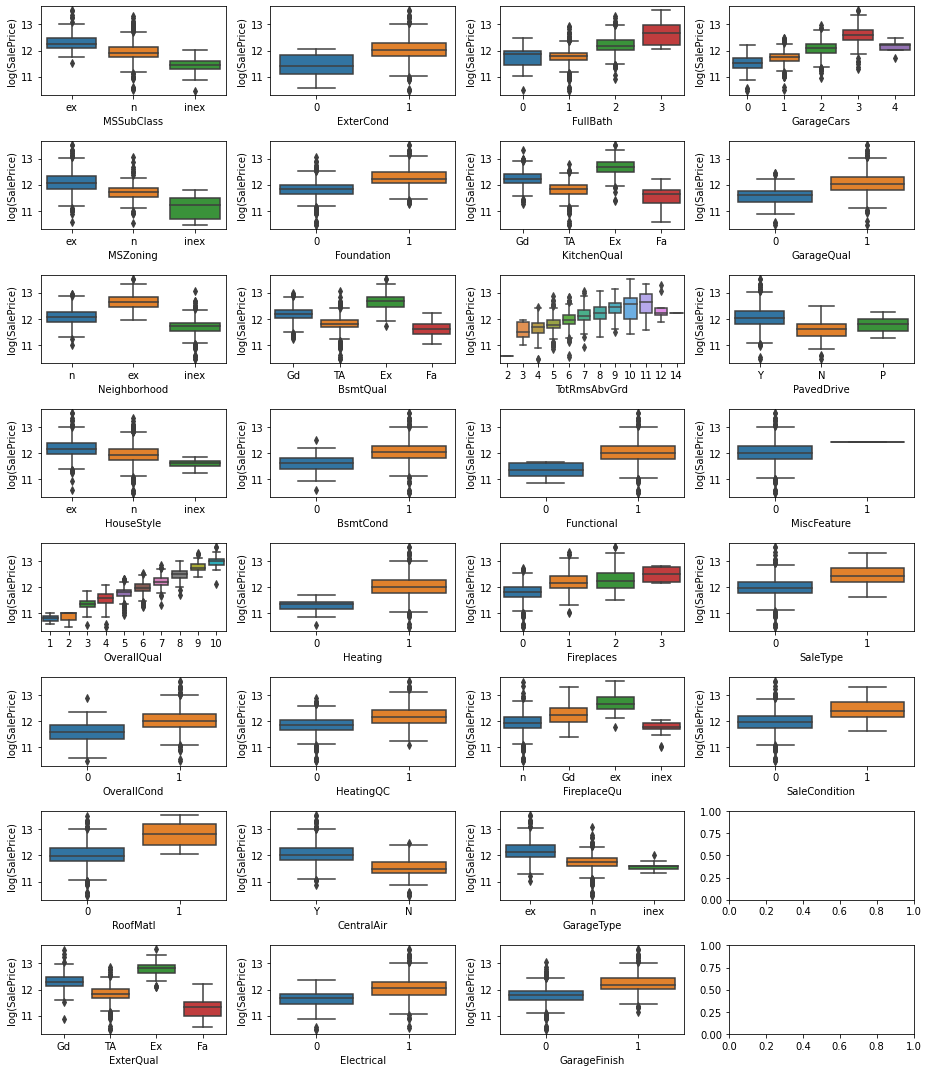

In [49]:
# We can see the result of the categorical tranformation
view_categoricals(8, 4, categorical_columns2)

In [50]:
# We will not only work with attributes we are interested in and have tranformed.
new_data = training_data[numerical_columns3 + categorical_columns2]

As a final transformation, we use get_dummies to change all of our remaining categorical variables with strings as inputs into their own indicator variables.

In [51]:
def categorize_onehot(data):
    return pd.get_dummies(data, columns = ["MSSubClass", "MSZoning", "Neighborhood", "HouseStyle", 
                        "ExterQual", "BsmtQual", "KitchenQual", "FireplaceQu", "GarageType", "PavedDrive", "CentralAir"]
                          , drop_first = True)

final_dataX = categorize_onehot(new_data)

In [52]:
final_dataX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   log(LotArea)       1449 non-null   float64
 1   YearBuilt          1449 non-null   int64  
 2   YearRemodAdd       1449 non-null   int64  
 3   log(TotalBsmtSF)   1449 non-null   float64
 4   log(1stFlrSF)      1449 non-null   float64
 5   log(BothFlrSF)     1449 non-null   float64
 6   log(GrLivArea)     1449 non-null   float64
 7   log(GarageArea)    1449 non-null   float64
 8   OverallQual        1449 non-null   int64  
 9   OverallCond        1449 non-null   int32  
 10  RoofMatl           1449 non-null   int32  
 11  ExterCond          1449 non-null   int32  
 12  Foundation         1449 non-null   int32  
 13  BsmtCond           1449 non-null   int32  
 14  Heating            1449 non-null   int32  
 15  HeatingQC          1449 non-null   int32  
 16  Electrical         1449 

In [53]:
from sklearn.preprocessing import StandardScaler

# For a lot of our models, it requires all our attributes to be in the same magnitude, we use the standard scalar
# This subtracts the value by the mean, and divides it by the standard deviation.
ss = StandardScaler()
ss.fit(final_dataX)
final_data_scaled = pd.DataFrame(ss.transform(final_dataX), columns = final_dataX.columns)

In [54]:
def load_process_data(train_path, test_path):
    """
    input:
    train_path (string): path name for the training data set
    test_path (string): path name for the test set
    
    output:
    the test set which has been cleaned up and transformed for the models
    """
    train = pd.read_csv(train_path).pipe(add_log)
    data = (pd.read_csv(test_path)
            .pipe(numerical_transform)
            .pipe(categorical_transform, train)[numerical_columns3 + categorical_columns2]
            .pipe(categorize_onehot))
    ss = StandardScaler()
    ss.fit(data)
    return pd.DataFrame(ss.transform(data), columns = data.columns)

In [55]:
test = load_process_data("train.csv", "test.csv").fillna(0)

# We make sure all the columns in our test set are exactly what we have in our training set.
for label in test.columns:
    if label not in final_dataX.columns:
        test = test.drop([label], axis=1)

# Modeling

Now that the data has been cleaned up, we test various types of regression models. To reduce overfitting and test our model, we first split our training data using a 4:1 split, and additionally do 4-fold cross validation and maximize for -RMSE. Random forest regressors are not used due its inability to extrapolate data.

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(final_data_scaled, training_data["log(SalePrice)"], test_size=0.20)

-0.1324087901612298
Ridge(alpha=40.45454545454545)


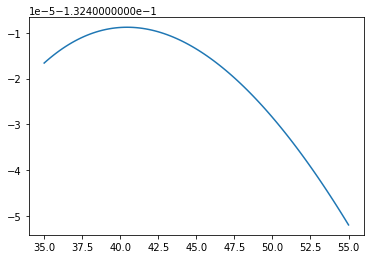

In [68]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params = {'alpha': np.linspace(35, 55, 100)}

grid_search = GridSearchCV(Ridge(), params, cv = 4, scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

plt.plot(np.linspace(35, 45, 100), grid_search.cv_results_['mean_test_score']);

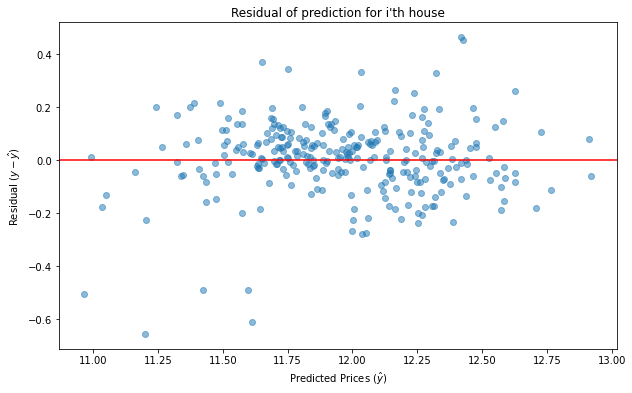

In [74]:
plt.figure(figsize=(10, 6))
predicted_values = grid_search.best_estimator_.predict(X_test)
plt.scatter(predicted_values, Y_test - predicted_values, alpha = 0.5)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Predicted Prices $(\hat{y})$")
plt.title("Residuals vs Predicted Prices")
plt.title("Residual of prediction for i'th house")
plt.axhline(y = 0, color='r');

In [75]:
prediction_rr = pd.DataFrame(np.exp(grid_search.best_estimator_.predict(test)), columns = ["SalePrice"])
prediction_rr["Id"] = pd.read_csv("test.csv")["Id"]
prediction_rr.to_csv("prediction_test_houseprices.csv", index = False)

-0.1321066789992731
ElasticNet(alpha=0.011, l1_ratio=0.1, max_iter=15000)


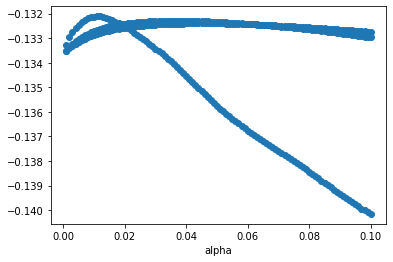

In [60]:
from sklearn.linear_model import ElasticNet

grid_values_en = {'l1_ratio': [0.001, 0.01, .1],
              'alpha': np.linspace(0.001, 0.1, 100),
              'max_iter': [15000]} 

en_cv = GridSearchCV(ElasticNet(), grid_values_en, cv = 4, scoring = "neg_root_mean_squared_error")
en_cv.fit(X_train, Y_train)

plt.figure()
plt.scatter(en_cv.cv_results_['param_alpha'].data , en_cv.cv_results_['mean_test_score'])
plt.xlabel("alpha")
print(en_cv.best_score_)
print(en_cv.best_estimator_)

In [61]:
prediction_en = pd.DataFrame(np.exp(en_cv.best_estimator_.predict(test)), columns = ["SalePrice"])
prediction_en["Id"] = pd.read_csv("test.csv")["Id"]
prediction_en.to_csv("prediction_test_houseprices_en.csv", index = False)

-0.1638011883659461
SVR(C=0.8526315789473683, degree=0.2, epsilon=0.030000000000000006)


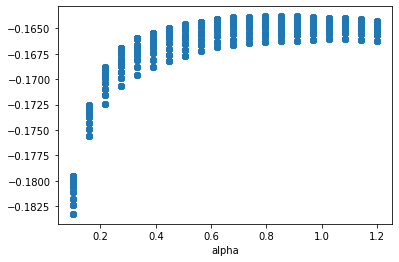

In [70]:
from sklearn.svm import SVR

grid_values_svr = {'degree': np.linspace(0.2, 1, 5),
              'C': np.linspace(0.1, 1.2, 20),
              'epsilon': np.linspace(0.01, 0.1, 10)} 

svr_cv = GridSearchCV(SVR(), grid_values_svr, cv = 4, scoring = "neg_root_mean_squared_error")
svr_cv.fit(X_train, Y_train)

plt.figure()
plt.scatter(svr_cv.cv_results_['param_C'].data , svr_cv.cv_results_['mean_test_score'])
plt.xlabel("alpha")
print(svr_cv.best_score_)
print(svr_cv.best_estimator_)

-0.13655867621530626
XGBRegressor(alpha=0.20473684210526316, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.29, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=0.1, missing=nan,
             monotone_constraints=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, ...)


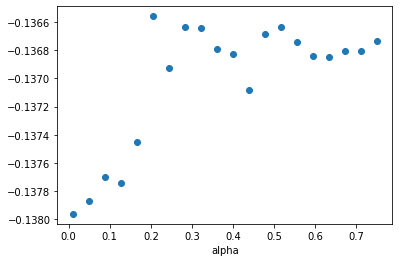

In [63]:
from xgboost import XGBRegressor

grid_values_xgb = {'n_estimators': [1500],
              'max_depth': [5],
              'eta': [0.01],
                'min_child_weight': [0.1],
                  'subsample': [0.79],
                  'colsample_bytree': [0.29],
                  'alpha': np.linspace(0.01, 0.75, 20)} 

xgb_cv = GridSearchCV(XGBRegressor(), grid_values_xgb, cv = 4, scoring = "neg_root_mean_squared_error")
xgb_cv.fit(X_train, Y_train)

plt.figure()
plt.scatter(xgb_cv.cv_results_['param_alpha'].data , xgb_cv.cv_results_['mean_test_score'])
plt.xlabel("alpha")
print(xgb_cv.best_score_)
print(xgb_cv.best_estimator_)

In [64]:
prediction_xgb = pd.DataFrame(np.exp(xgb_cv.best_estimator_.predict(test)), columns = ["SalePrice"])
prediction_xgb["Id"] = pd.read_csv("test.csv")["Id"]
prediction_xgb.to_csv("prediction_test_houseprices_xgb.csv", index = False)